Bilayer unit domain. Sigma optimisation

In [100]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [101]:
import matplotlib.pyplot as plt

try:
	if "science" not in plt.style.available:
		try:
			import scienceplots  # registers styles if installed
		except Exception:
			# Install SciencePlots (registers the 'science' style) and import it
			get_ipython().run_line_magic('pip', 'install -q SciencePlots')
			import scienceplots  # noqa: F401
	plt.style.use(["science", "grid"])
except Exception as e:
	# If anything fails, fall back to a commonly available style
	print("Warning: 'science' style not available. Using 'seaborn' instead. Error:", e)
	plt.style.use("seaborn")

In [102]:
import matplotlib as mpl
colors_list = [
    "#0C5DA5",  # blue
    "#00B945",  # green
    "#FF9500",  # orange
    "#FF2C00",  # red
    "#845B97",  # purple
    "#474747",  # dark gray
    "#9e9e9e",  # light gray
]

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=colors_list)
mpl.rcParams.update({
    # Tamaño físico
    "figure.figsize": (2.9, 2.6),

    # Líneas
    "lines.linewidth": 2.0,
    "lines.markersize": 7,

    # Fuente de títulos, labels y leyendas
    "font.size": 20,
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "legend.fontsize": 18,

    # Números de los ejes un pelín más pequeños
    "xtick.labelsize": 15.5,
    "ytick.labelsize": 15.5,

    # Ejes y ticks
    "axes.linewidth": 1.4,
    "xtick.major.width": 1.4,
    "ytick.major.width": 1.4,

    # PDF limpio
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


In [103]:
# Importing libraries
from matplotlib import ticker
from dolfinx import geometry
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh, meshtags
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from dolfinx.geometry import bb_tree
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  

Domain, PML, refinement and physical configurations

In [104]:
# Define element size for the mesh refinement
h_i = [0.125/32]   
N=np.log2(0.125/h_i[0])
# Domain configuration
Lx = 1. # fluid domain length (without PML)

# Physical configuration for 5 layers
rho_media_1 = 1.0  # kg/m^3
rho_media_2 = 1.0  # kg/m^3
rho_media_3 = 1.0  # kg/m^3
rho_media_4 = 1.0  # kg/m^3
rho_media_5 = 1.0  # kg/m^3

vel_media_1 = 0.2  # m/s
vel_media_2 = 0.5  # m/s
vel_media_3 = 2.5  # m/s
vel_media_4 = 1.  # m/s
vel_media_5 = 0.8  # m/s

# Layer boundaries
l1 = 0.3
l2 = 0.4
l3 = 0.45
l4 = 0.8

# Define the density function
def rho_function(x):
    conditions = [x[0] <= l1,
                  (x[0] > l1) & (x[0] <= l2),
                  (x[0] > l2) & (x[0] <= l3),
                  (x[0] > l3) & (x[0] <= l4),
                  x[0] > l4]
    values = [rho_media_1, rho_media_2, rho_media_3, rho_media_4, rho_media_5]
    return np.select(conditions, values)

# Define the velocity function
def vel_function(x):
    conditions = [x[0] <= l1,
                  (x[0] > l1) & (x[0] <= l2),
                  (x[0] > l2) & (x[0] <= l3),
                  (x[0] > l3) & (x[0] <= l4),
                  x[0] > l4]
    values = [vel_media_1, vel_media_2, vel_media_3, vel_media_4, vel_media_5]
    return np.select(conditions, values)


# PML configuration
pml_thickness = Lx/4

# Solver configuration
requested_eigenvalues_number = 200 # Number of eigenvalues to compute
target=-5j # Target for the shift-and-invert spectral transformation
degree=[2,1]  # Polynomial degree for pressure and velocity

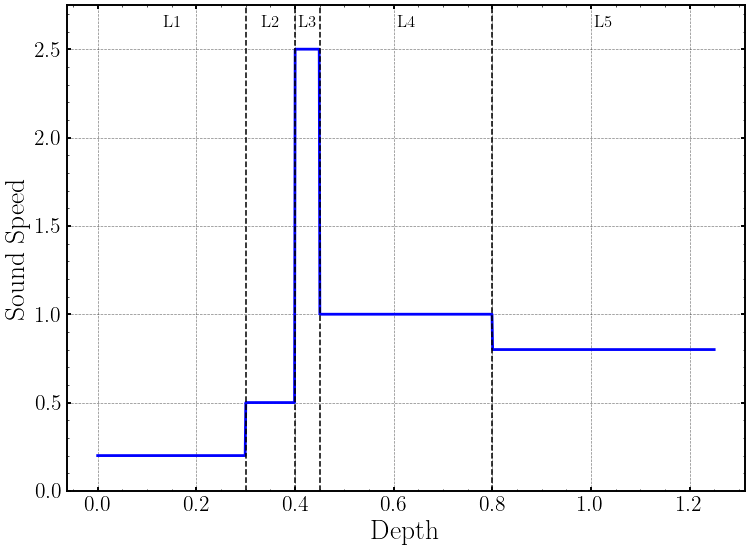

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un array de puntos no dominio, incluíndo PML se queres
xx = np.linspace(0, Lx + pml_thickness, 1000)

# Avaliar a velocidade en todos os puntos
vel_values = np.array([vel_function([x]) for x in xx])

# Plot
plt.figure(figsize=(8,6))
plt.plot(xx, vel_values, '-', color='blue', linewidth=2)
plt.xlabel("Depth")
plt.ylabel("Sound Speed")
# plt.title("Perfil de velocidade en profundidade")
plt.grid(True)

# Engadir liñas verticais para as fronteiras das capas
for l in [l1, l2, l3, l4]:
    plt.axvline(x=l, color='k', linestyle='--', linewidth=1.1)

# Engadir etiquetas das capas
plt.text(0.5*l1, max(vel_values)*1.05, "L1", ha='center', size=12)
plt.text((l1+l2)/2, max(vel_values)*1.05, "L2", ha='center', size=12)
plt.text((l2+l3)/2, max(vel_values)*1.05, "L3", ha='center', size=12)
plt.text((l3+l4)/2, max(vel_values)*1.05, "L4", ha='center', size=12)
plt.text((l4 + (Lx + pml_thickness))/2, max(vel_values)*1.05, "L5", ha='center', size=12)
plt.ylim([0, max(vel_values)*1.1])
plt.tight_layout()
plt.savefig("velocity_profile_fig_1.pdf", bbox_inches='tight')
plt.show()

Solver configuration and computing

In [105]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Define the subdomains using a Python function
    TOL = 1e-6
    def pml_domain(x):
        """Returns True for points in (Lx, Lx + pml_thickness]"""
        return x[0] > Lx - TOL

    # Get topology dimension
    tdim = mesh.topology.dim

    # Locate cells in each subdomain
    pml_cells = locate_entities(mesh, tdim, pml_domain)

    # Create a meshtag to mark the subdomains
    num_cells = mesh.topology.index_map(tdim).size_local
    cell_markers = np.ones(num_cells, dtype=np.int32) # Physical domain tag=1
    cell_markers[pml_cells] = 2       # PML domain tag=2

    cell_tags = meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)

    # Now you can use these tags for integration measures
    dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 0))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q)
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx(2), -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx(2)],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert"
    solver.setTarget(target)
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [106]:
def assign_eigenvector_to_functions(vrA, p_h, v_h, dof):
    """
    Reparte o vector eigenvector 'vrA' entre p_h e v_h
    e normaliza no punto 'normalize_at'.
    """

    # --- separar as partes do autovector ---
    p_vals = vrA[:dof["p"]]
    v_vals = vrA[dof["p"]:]

    # asignar
    p_h.x.array[:] = p_vals
    v_h.x.array[:] = v_vals

    return p_h, v_h

In [107]:
def eval_point_fast(u, bb, x, mesh):
    pt = np.array([x, 0.0, 0.0], dtype=np.float64)

    # 1) Buscamos celas candidatas no árbol
    candidates = geometry.compute_collisions_points(bb, pt)

    # 2) Filtramos celas que realmente conteñen o punto
    cell = geometry.compute_colliding_cells(mesh, candidates, pt)

    if len(cell) == 0:
        return np.nan

    # 3) Avaliar a función FEM
    P = np.array([pt])
    C = np.array([cell.array[0]], dtype=np.int32)

    val = u.eval(P, C)
    return val[0]

In [108]:
def get_eigenpair(solver, index, Q, V, dof, mesh):

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vr, vi = solver.getOperators()[0].getVecs()
    omega_h=solver.getEigenpair(index, vr) * 1j
    bb = bb_tree(mesh, mesh.topology.dim)

    p_h = Function(Q, name="p_h")
    v_h = Function(V, name="v_h")
    [p_h, v_h]=assign_eigenvector_to_functions(vrA = vr, p_h = p_h, v_h = v_h, dof = dof)
    val_Lx = eval_point_fast(p_h, bb, Lx, mesh)
    p_h.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    val_Lx = eval_point_fast(v_h, bb, Lx, mesh)
    v_h.x.array[:] /= val_Lx   # normalizando respecto do valor en [Lx, 0, 0]
    return omega_h, p_h, v_h


In [109]:
configuration= "mixed_example" #"optimal_N_5"  #"optimal_N_5" #
match configuration:
    case 'optimal_N_1':
        sigma_0_piecewise=16
        sigma_0_quadratic= 61
    case 'optimal_N_5':
        sigma_0_piecewise=35
        sigma_0_quadratic= 124
    case 'mixed_example':
        sigma_0_piecewise= 10  #5
        sigma_0_quadratic= 30   # 15


# Create mesh depending on h
mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[0]), [0, Lx + pml_thickness])

# Define PIECEWISE sigma function
sigma_x=lambda x: sigma_0_piecewise
# Define solver for piecewise PML
[solver_p, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x, target)
nconv_p = min(solver_p.getConverged(), 100)
approx=[None]*nconv_p
for j in np.arange(0, nconv_p,1):
    # Get the approximated eigenpair (solver, index, Q, V, dof, mesh)
    approx[j] = get_eigenpair(solver_p, j, Q_, V_, dof_, mesh)[0]
eigs_piecewise=[]
eigv_p_piecewise=[]
eigv_v_piecewise=[]
vr, vi = solver_p.getOperators()[0].getVecs()
for k in np.arange(solver_p.getConverged()):
    eigs_piecewise.append(get_eigenpair(solver_p, k, Q_, V_, dof_, mesh)[0])
    eigv_p_piecewise.append(get_eigenpair(solver_p, k, Q_, V_, dof_, mesh)[1])
    eigv_v_piecewise.append(get_eigenpair(solver_p, k, Q_, V_, dof_, mesh)[2])

In [110]:
# Define sigma function
sigma_x=lambda x: sigma_0_quadratic*(x[0]-Lx)**2/(pml_thickness**2)
# Define solver for piecewise PML
[solver_q, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x, target)
nconv_q = min(solver_q.getConverged(), 100)
approx=[None]*nconv_q
for j in np.arange(0, nconv_q,1):
    # Get the approximated eigenpair
    approx[j] = get_eigenpair(solver_p, j, Q_, V_, dof_, mesh)[0]
eigs_quadratic=[]
eigv_p_quadratic=[]
eigv_v_quadratic=[]
vr, vi = solver_q.getOperators()[0].getVecs()
for k in np.arange(solver_q.getConverged()):
    eigs_quadratic.append(get_eigenpair(solver_q, k, Q_, V_, dof_, mesh)[0])
    eigv_p_quadratic.append(get_eigenpair(solver_q, k, Q_, V_, dof_, mesh)[1])
    eigv_v_quadratic.append(get_eigenpair(solver_q, k, Q_, V_, dof_, mesh)[2])

In [111]:
sigma_0_singular=1

# Define PIECEWISE sigma function
sigma_x=lambda x: sigma_0_singular/(Lx+pml_thickness-x[0])

# Define solver for piecewise PML
[solver_s, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x, target)
nconv_s = min(solver_s.getConverged(), 100)
approx=[None]*nconv_s
for j in np.arange(0, nconv_s,1):
    # Get the approximated eigenpair
    approx[j] = get_eigenpair(solver_p, j, Q_, V_, dof_, mesh)[0]
eigs_singular=[]
eigv_p_singular=[]
eigv_v_singular=[]
vr, vi = solver_s.getOperators()[0].getVecs()
for k in np.arange(solver_s.getConverged()):
    eigs_singular.append(get_eigenpair(solver_s, k, Q_, V_, dof_, mesh)[0])
    eigv_p_singular.append(get_eigenpair(solver_s, k, Q_, V_, dof_, mesh)[1])
    eigv_v_singular.append(get_eigenpair(solver_s, k, Q_, V_, dof_, mesh)[2])

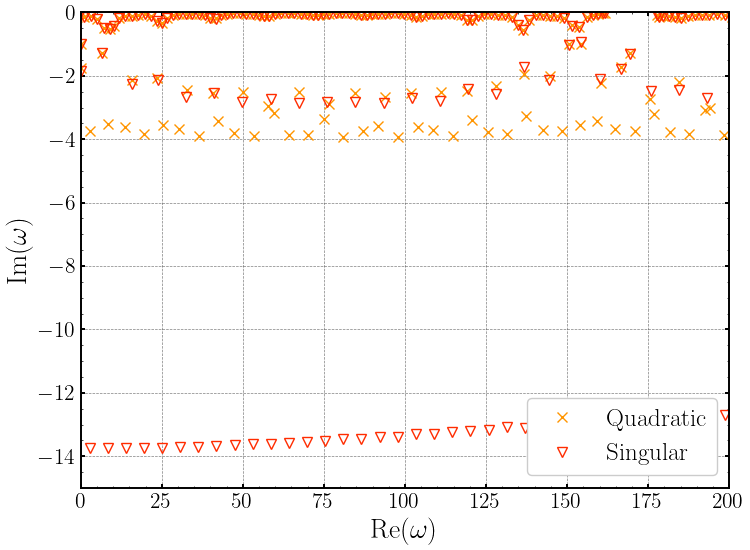

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, ax = plt.subplots(figsize=(8,6))

# Try to use the 'science' style; if it's not available, attempt to install SciencePlots,
# otherwise fall back to a safe default style.


# Plote principal
# ax.plot(np.real(exact_omega), np.imag(exact_omega), 's', markerfacecolor='none', color=colors_list[0], label='Exact')
# ax.plot(np.real(eigs_piecewise), np.imag(eigs_piecewise), 'o', markerfacecolor='none', color=colors_list[1], label='Constant')
ax.plot(np.real(eigs_quadratic), np.imag(eigs_quadratic), marker='x',linestyle='none', markerfacecolor='none', color=colors_list[2], label='Quadratic')
ax.plot(np.real(eigs_singular), np.imag(eigs_singular), 'v', markerfacecolor='none', color=colors_list[3], label='Singular')


ax.set_xlabel(r'$\mathrm{Re}(\omega)$')
ax.set_ylabel(r'$\mathrm{Im}(\omega)$')
ax.grid(True)
# ax.set_title(f'Spectrum for N={N}')
plt.xlim([0,200])
# plt.ylim([-14, 0])
x_10_elementos = (2*np.pi*min(vel_media_1, vel_media_2))/(10*h_i[0]**degree[0])  # valor onde queres a liña vertical
ax.axvline(x=x_10_elementos, color='k', linestyle='--', linewidth=1.5)

plt.ylim([-15, 0])
# Sen rectángulo de zoom
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f"1D_bicapa_espectro_N_{N}_{degree}_{configuration}.pdf", bbox_inches="tight")
plt.show()


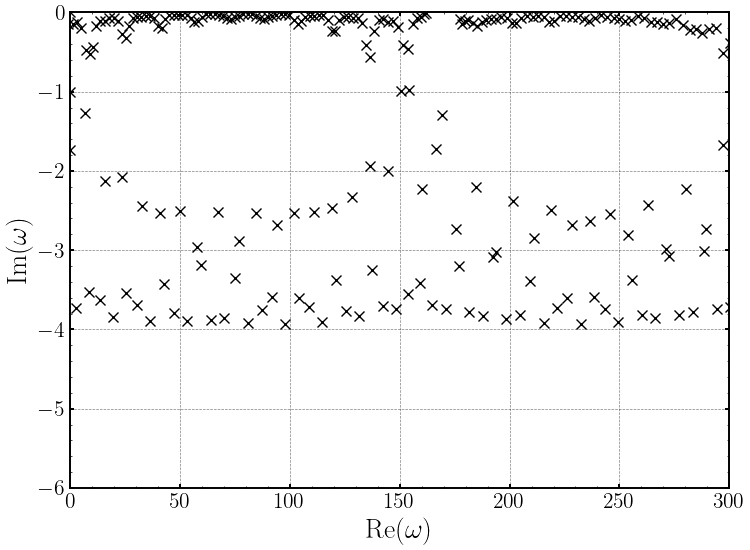

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


fig, ax = plt.subplots(figsize=(8,6))

# Try to use the 'science' style; if it's not available, attempt to install SciencePlots,
# otherwise fall back to a safe default style.


# Plote principal
ax.plot(np.real(eigs_quadratic), np.imag(eigs_quadratic), marker='x',linestyle='none', markerfacecolor='none', color='black', label='Quadratic')


ax.set_xlabel(r'$\mathrm{Re}(\omega)$')
ax.set_ylabel(r'$\mathrm{Im}(\omega)$')
ax.grid(True)
# ax.set_title(f'Spectrum for N={N}')
plt.xlim([0,300])
plt.ylim([-6, 0])
x_10_elementos = (2*np.pi*min(vel_media_1, vel_media_2))/(10*h_i[0]**degree[0])  # valor onde queres a liña vertical
ax.axvline(x=x_10_elementos, color='k', linestyle='--', linewidth=1.5)

# plt.ylim([-20, 0])
# Sen rectángulo de zoom
# ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f"1D_bicapa_espectro_N_{N}_{degree}_{configuration}_quadratic_{sigma_0_quadratic}.pdf", bbox_inches="tight")
plt.show()


In [114]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
from IPython.display import display

# Supoñendo que estes datos xa existen
# eigs_piecewise, eigv_p_piecewise, etc.
xx = np.linspace(0, Lx + pml_thickness, 2000)

def plot_eigenvector(selected_index=0, pml_profile="piecewise"):
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Selección do autovector segundo o perfil
    match pml_profile:
        case 'piecewise':
            eig = eigs_piecewise[selected_index]
            p = eigv_p_piecewise[selected_index]
            label = "Constant"
        case 'quadratic':
            eig = eigs_quadratic[selected_index]
            p = eigv_p_quadratic[selected_index]
            label = "Quadratic"
        case 'singular':
            eig = eigs_singular[selected_index]
            p = eigv_p_singular[selected_index]
            label = "Singular"
    
    print(f"Selected eigenvalue: {eig}")
    bb = bb_tree(mesh, mesh.topology.dim)
    val_Lx = eval_point_fast(p, bb, Lx, mesh)
    p.x.array[:] /= val_Lx
    
    yy = np.array([eval_point_fast(p, bb, x, mesh) for x in xx])
    
    ax.plot(xx, np.real(yy), '-', label=label)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\\mathrm{Re}(p)$")
    ax.grid(True)
    ax.set_ylim([-1.3, 1.3])
    ax.legend()
    plt.show()

# Interfaz interactiva
interact(
    plot_eigenvector,
    selected_index=IntSlider(min=0, max=len(eigs_piecewise)-1, step=1, value=0),
    pml_profile=Dropdown(options=["piecewise", "quadratic", "singular"], value="piecewise")
)

interactive(children=(IntSlider(value=0, description='selected_index', max=477), Dropdown(description='pml_pro…

<function __main__.plot_eigenvector(selected_index=0, pml_profile='piecewise')>

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntText, Dropdown
from IPython.display import display

def interactive_spectrum(selected_index=0, pml_profile="piecewise"):
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    # ==== Espectro completo ====
    ax_spec = axs[0]
    ax_spec.plot(np.real(eigs_piecewise), np.imag(eigs_piecewise), 'o', markerfacecolor='none', color=colors_list[1], label='Constant')
    ax_spec.plot(np.real(eigs_quadratic), np.imag(eigs_quadratic), '^', markerfacecolor='none', color=colors_list[2], label='Quadratic')
    ax_spec.plot(np.real(eigs_singular), np.imag(eigs_singular), 'v', markerfacecolor='none', color=colors_list[3], label='Singular')
    
    # Selección do autovalor
    match pml_profile:
        case 'piecewise':
            selected_eig = eigs_piecewise[selected_index]
        case 'quadratic':
            selected_eig = eigs_quadratic[selected_index]
        case 'singular':
            selected_eig = eigs_singular[selected_index]
    
    ax_spec.plot(np.real(selected_eig), np.imag(selected_eig), 'o', markerfacecolor='none', color='blue',markeredgewidth=3, markersize=10, label='Selected')

    ax_spec.set_xlabel(r'$\mathrm{Re}(\omega)$')
    ax_spec.set_ylabel(r'$\mathrm{Im}(\omega)$')
    ax_spec.grid(True)
    ax_spec.legend()
    ax_spec.set_xlim([0, 200])
    ax_spec.set_ylim([-20, 0])

    # ==== Autovector (presión) ====
    ax_p = axs[1]
    match pml_profile:
        case 'piecewise':
            p = eigv_p_piecewise[selected_index]
            label = "Constant"
        case 'quadratic':
            p = eigv_p_quadratic[selected_index]
            label = "Quadratic"
        case 'singular':
            p = eigv_p_singular[selected_index]
            label = "Singular"
    bb = bb_tree(mesh, mesh.topology.dim)
    val_Lx = eval_point_fast(p, bb, Lx, mesh)
    p.x.array[:] /= val_Lx
    yy = np.array([eval_point_fast(p, bb, x, mesh) for x in xx])
    
    ax_p.plot(xx, np.real(yy), '-', label=label)
    ax_p.set_xlabel("$x$")
    ax_p.set_ylabel("$\\mathrm{Re}(p)$")
    ax_p.grid(True)
    ax_p.set_ylim([-1.3, 1.3])
    ax_p.legend()

# ==== Engadir o valor do autovalor fóra do gráfico do autovector ====
    fig.text(
        0.6,  # coordenada x en fracción da figura (fóra á dereita)
        0.98,   # coordenada y en fracción da figura (centro vertical)
        f"Selected eigenvalue: {selected_eig:.3f}",
        color='black',
        fontsize=20,
        ha='left',
        # va='center'
    )

    plt.tight_layout()
    plt.show()

# Widget interactivo
interact(
    interactive_spectrum,
    selected_index=IntText(value=0, description='Índice:', min=0, max=len(eigs_piecewise)-1),
    pml_profile=Dropdown(options=["piecewise", "quadratic", "singular"], value="piecewise")
)

interactive(children=(IntText(value=0, description='Índice:'), Dropdown(description='pml_profile', options=('p…

<function __main__.interactive_spectrum(selected_index=0, pml_profile='piecewise')>